In [3]:
import zipfile
import pandas as pd
import os

# Step 1: Unzip the uploaded file
zip_path = "/content/archive (2).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# List files in the extracted directory to find the correct filename
extracted_files = os.listdir("/content/")
print("Files extracted to /content/:", extracted_files)


# Step 2: Find and load the CSV file (update if filename differs)
# Update the file_path with the correct filename from the extracted files
file_path = "/content/Telco_customer_churn.xlsx" # Corrected filename and extension
df = pd.read_excel(file_path) # Changed to read_excel

# Step 3: Preview and basic info
print("Shape:", df.shape)
print("Columns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
df.head()

Files extracted to /content/: ['.config', 'archive (2).zip', 'Telco_customer_churn.xlsx', 'sample_data']
Shape: (7043, 33)
Columns:
 Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

Missing values:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen      

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
# Make a copy of the data
df_clean = df.copy()

# 1. Convert Total Charges to numeric
df_clean["Total Charges"] = pd.to_numeric(df_clean["Total Charges"], errors='coerce')

# 2. Drop unnecessary columns
cols_to_drop = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
                'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason']
df_clean.drop(columns=cols_to_drop, inplace=True)

# 3. Drop rows with missing values
df_clean.dropna(inplace=True)

# 4. Confirm Churn Value is target
df_clean['Churn Value'] = df_clean['Churn Value'].astype(int)

# 5. Encode categorical columns (One-Hot)
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# Check final shape
print("Cleaned data shape:", df_encoded.shape)
df_encoded.head()

Cleaned data shape: (7032, 33)


,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,2,53.85,108.15,1,86,3239,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,2,70.70,151.65,1,67,2701,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
2,8,99.65,820.50,1,86,5372,False,False,False,True,...,False,True,False,True,False,False,True,False,True,False
3,28,104.80,3046.05,1,84,5003,False,False,True,True,...,False,True,False,True,False,False,True,False,True,False
4,49,103.70,5036.30,1,89,5340,True,False,False,True,...,False,True,False,True,False,False,True,False,False,False


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Define features and target
X = df_encoded.drop('Churn Value', axis=1)
y = df_encoded['Churn Value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# 2. Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# 3. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)


Logistic Regression Evaluation:
Accuracy: 0.914001421464108
ROC AUC: 0.8923687897133137
Confusion Matrix:
 [[953  59]
 [ 62 333]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1012
           1       0.85      0.84      0.85       395

    accuracy                           0.91      1407
   macro avg       0.89      0.89      0.89      1407
weighted avg       0.91      0.91      0.91      1407


Random Forest Evaluation:
Accuracy: 0.9275053304904051
ROC AUC: 0.9048431480462301
Confusion Matrix:
 [[968  44]
 [ 58 337]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1012
           1       0.88      0.85      0.87       395

    accuracy                           0.93      1407
   macro avg       0.91      0.90      0.91      1407
weighted avg       0.93      0.93      0.93      1407


XGBoost Evaluation:
Accuracy: 0.91897654

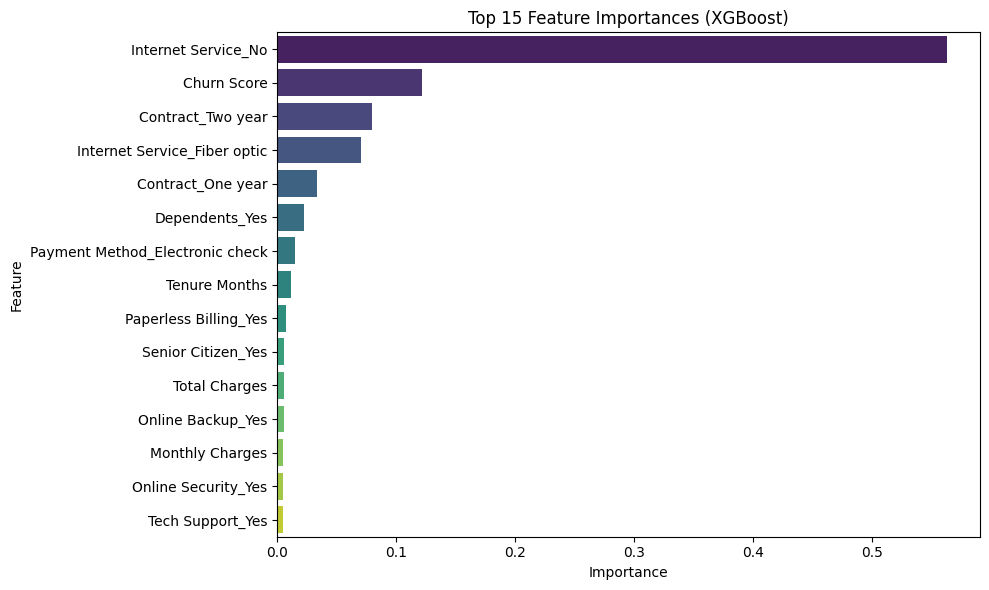

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 15 important features
importances = xgb_model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [7]:
# Add churn probability to test set predictions
churn_probs = xgb_model.predict_proba(X_test)[:, 1]

# Create result dataframe for Power BI
results_df = X_test.copy()
results_df['Actual Churn'] = y_test.values
results_df['Predicted Churn'] = xgb_preds
results_df['Churn Probability'] = churn_probs

# Optional: Round and export
results_df['Churn Probability'] = results_df['Churn Probability'].round(4)
results_df.to_csv("xgboost_churn_predictions.csv", index=False)